In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
print(tf.__version__)

2.11.0


In [4]:
# Load the data

path = "/home/guts/Documents/accel_data/acceleration_data.csv"
df = pd.read_csv(path)
df

,Timestamp,Acceleration
0,2024-08-09 14:23:41,10.110164
1,2024-08-09 14:23:42,9.555678
2,2024-08-09 14:23:44,9.325334
3,2024-08-09 14:23:48,9.532025
4,2024-08-09 14:23:49,9.468498
...,...,...
18662,2024-08-10 01:05:10,9.490646
18663,2024-08-10 01:05:13,10.447052
18664,2024-08-10 01:05:15,9.073947
18665,2024-08-10 01:05:16,10.054511


In [5]:
# Preprocess the data if needed

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Timestamp'] = df['Timestamp'].dt.floor('s')
df

,Timestamp,Acceleration
0,2024-08-09 14:23:41,10.110164
1,2024-08-09 14:23:42,9.555678
2,2024-08-09 14:23:44,9.325334
3,2024-08-09 14:23:48,9.532025
4,2024-08-09 14:23:49,9.468498
...,...,...
18662,2024-08-10 01:05:10,9.490646
18663,2024-08-10 01:05:13,10.447052
18664,2024-08-10 01:05:15,9.073947
18665,2024-08-10 01:05:16,10.054511


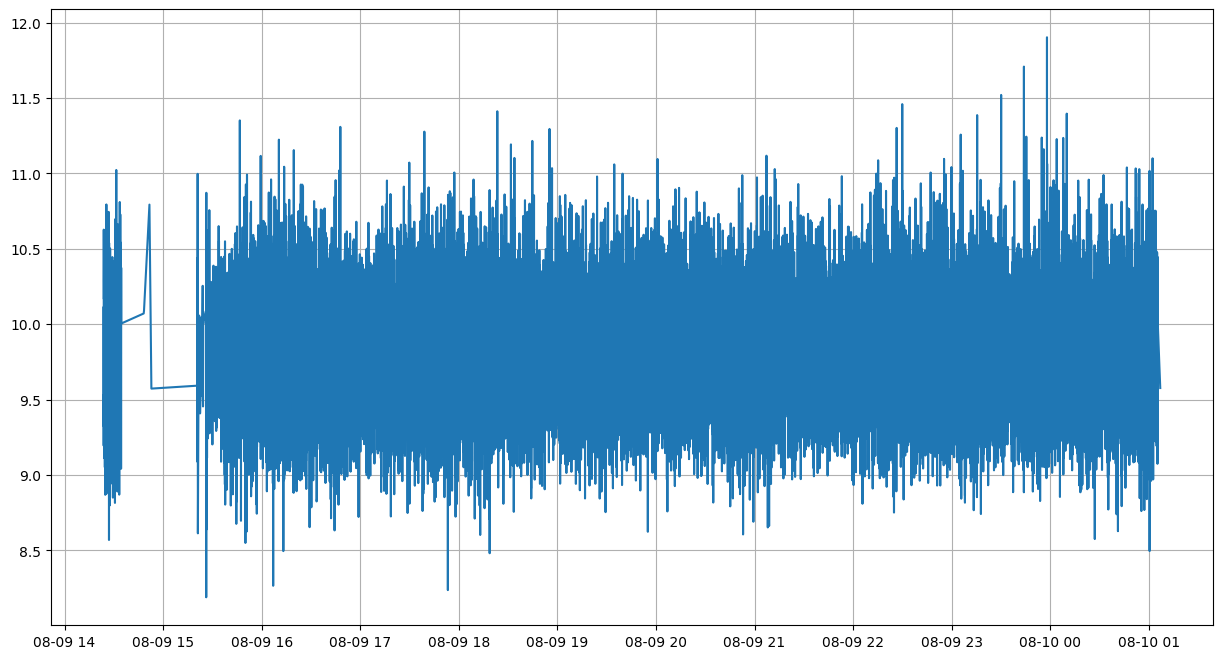

In [6]:
# Plot the data

plt.figure(figsize=(15, 8))
plt.plot(df['Timestamp'], df['Acceleration'])
plt.grid()

plt.show()

In [7]:
# Function to convert a DataFrame to input sequences and labels for a time series prediction model
def df_to_x_y(df, window_size):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]] # Create a 2D array of the current window of data
        x.append(row) # Append the 2D array to the input sequences list
        label = df_as_np[i+window_size] # Append the label for the next element to the labels list
        y.append(label)
    return np.array(x), np.array(y)

In [8]:
WINDOW_SIZE = 5
x, y =df_to_x_y(df['Acceleration'], WINDOW_SIZE)
x.shape, y.shape

((18662, 5, 1), (18662,))

In [9]:
# Split the data into train, test and validation

X_train, y_train = x[:12000], y[:12000]
X_val, y_val = x[12000:17000], y[12000:17000]
X_test, y_test = x[17000:], y[17000:]

In [13]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, InputLayer, StackedRNNCells, LSTMCell, RNN


# Define LSTM cells
lstm_cell_1 = LSTMCell(units=300)
lstm_cell_2 = LSTMCell(units=150)
lstm_cell_3 = LSTMCell(units=75)


# Stack the LSTM cells
stacked_lstm = StackedRNNCells([lstm_cell_1, lstm_cell_2, lstm_cell_3])

# Create the RNN layer with the stacked LSTM cells
rnn_layer = RNN(stacked_lstm)

# Build the model
model1 = Sequential()
model1.add(InputLayer(input_shape=(WINDOW_SIZE, 1)))  # Define input shape
model1.add(rnn_layer)  # Add the custom stacked RNN layer
model1.add(Dense(30, activation='relu'))  # Fully connected layer
model1.add(Dense(1))  # Output layer

# Print the model summary
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_1 (RNN)                 (None, 75)                700800    
                                                                 
 dense_2 (Dense)             (None, 30)                2280      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 703,111
Trainable params: 703,111
Non-trainable params: 0
_________________________________________________________________


In [14]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

# Create a callback to save the best model during training

cp = ModelCheckpoint(filepath='models/best_model.h5', save_best_only=True)
model1.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

In [15]:
# Train the model
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[cp])

Epoch 1/10
375/375 [==============================] - 14s 31ms/step - loss: 2.1234 - root_mean_squared_error: 1.4572 - val_loss: 0.2000 - val_root_mean_squared_error: 0.4473
Epoch 2/10
375/375 [==============================] - 11s 30ms/step - loss: 0.2022 - root_mean_squared_error: 0.4496 - val_loss: 0.2002 - val_root_mean_squared_error: 0.4475
Epoch 3/10
375/375 [==============================] - 12s 32ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509 - val_loss: 0.2002 - val_root_mean_squared_error: 0.4475
Epoch 4/10
375/375 [==============================] - 11s 29ms/step - loss: 0.2031 - root_mean_squared_error: 0.4507 - val_loss: 0.2008 - val_root_mean_squared_error: 0.4481
Epoch 5/10
375/375 [==============================] - 13s 35ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542 - val_loss: 0.1999 - val_root_mean_squared_error: 0.4471
Epoch 6/10
375/375 [==============================] - 10s 26ms/step - loss: 0.2057 - root_mean_squared_error: 0.4536 - val_loss: 0

In [16]:
from tensorflow.keras.models import load_model

# Load the best model
model1 = load_model('models/best_model.h5')

In [17]:
# Evaluate the model on the test data

train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions' :train_predictions, 'Actual' :y_train})
train_results

375/375 [==============================] - 4s 9ms/step


,Train Predictions,Actual
0,9.828204,9.194019
1,9.827709,10.122995
2,9.827501,10.627051
3,9.827696,10.394547
4,9.827627,10.291631
...,...,...
11995,9.827393,10.083018
11996,9.827687,9.572912
11997,9.827491,9.591625
11998,9.828198,9.495026


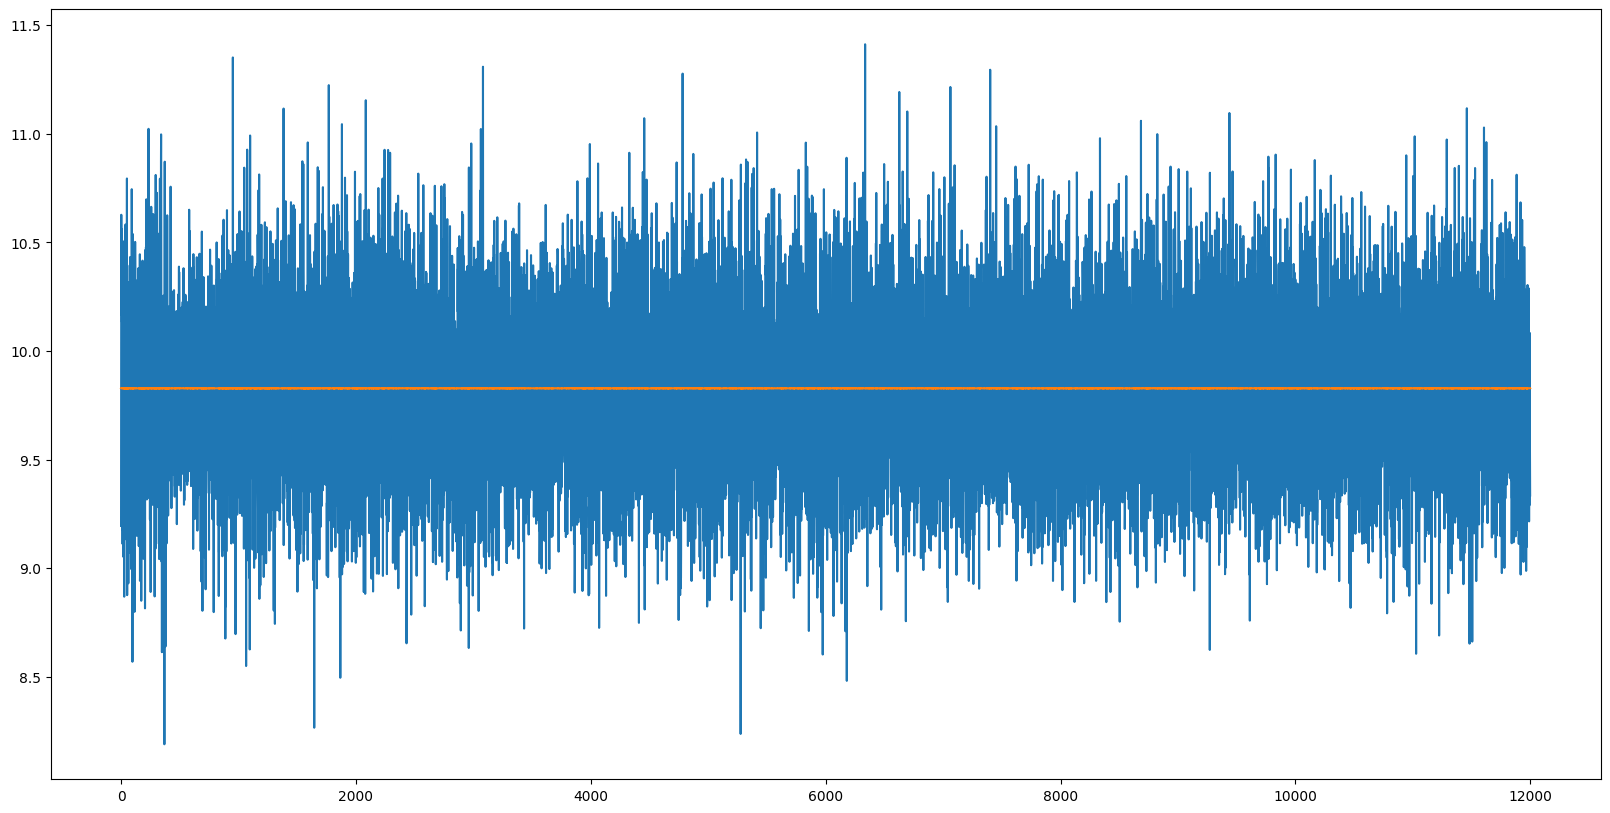

In [18]:
# Plot the predictions and actual values

plt.figure(figsize=(20,10))
plt.plot(train_results['Actual'])
plt.plot(train_results['Train Predictions'])


In [19]:
# Generate predictions for the validation set using model1 and flatten the result to a 1D array

val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actual': y_val})
val_results

157/157 [==============================] - 2s 9ms/step


,Val Predictions,Actual
0,9.828184,9.160687
1,9.827739,9.536050
2,9.827750,9.563928
3,9.827653,10.201605
4,9.827494,10.128941
...,...,...
4995,9.827603,10.072212
4996,9.827724,10.284606
4997,9.827741,10.285126
4998,9.827513,9.460601


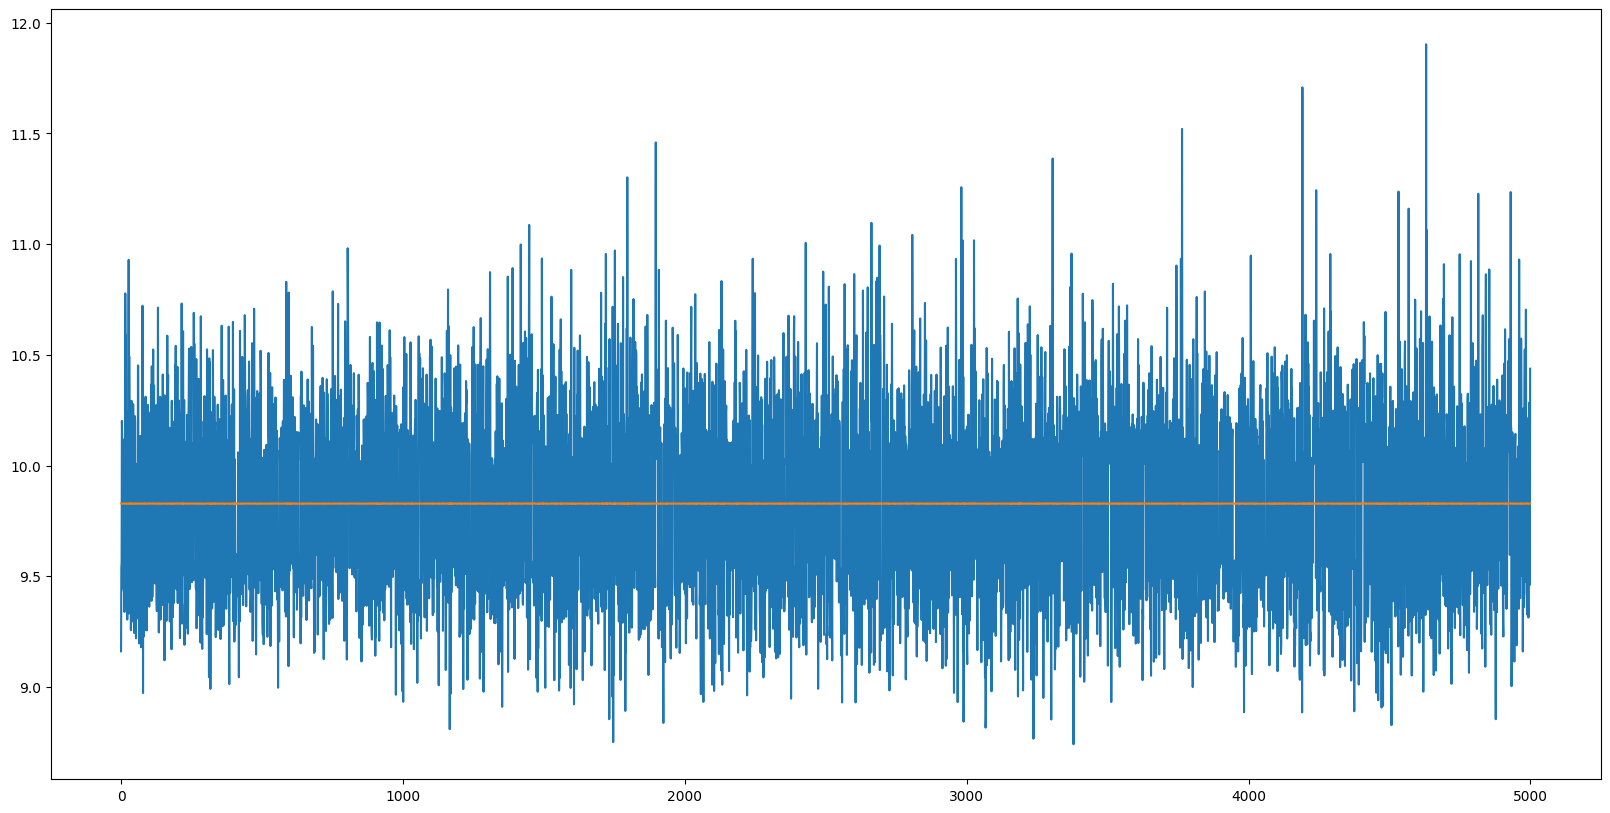

In [20]:
# Plot the predictions and actual values for the validation set

plt.figure(figsize=(20,10))
plt.plot(val_results['Actual'])
plt.plot(val_results['Val Predictions'])

In [21]:
# Generate predictions for the test set using model1 and flatten the result to a 1D array

test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions' :test_predictions, 'Actual' :y_test})
test_results

52/52 [==============================] - 1s 11ms/step


,Test Predictions,Actual
0,9.828199,9.586499
1,9.828370,11.396490
2,9.828348,9.348668
3,9.827669,10.088757
4,9.828470,10.278618
...,...,...
1657,9.828255,9.490646
1658,9.827518,10.447052
1659,9.828140,9.073947
1660,9.827749,10.054511


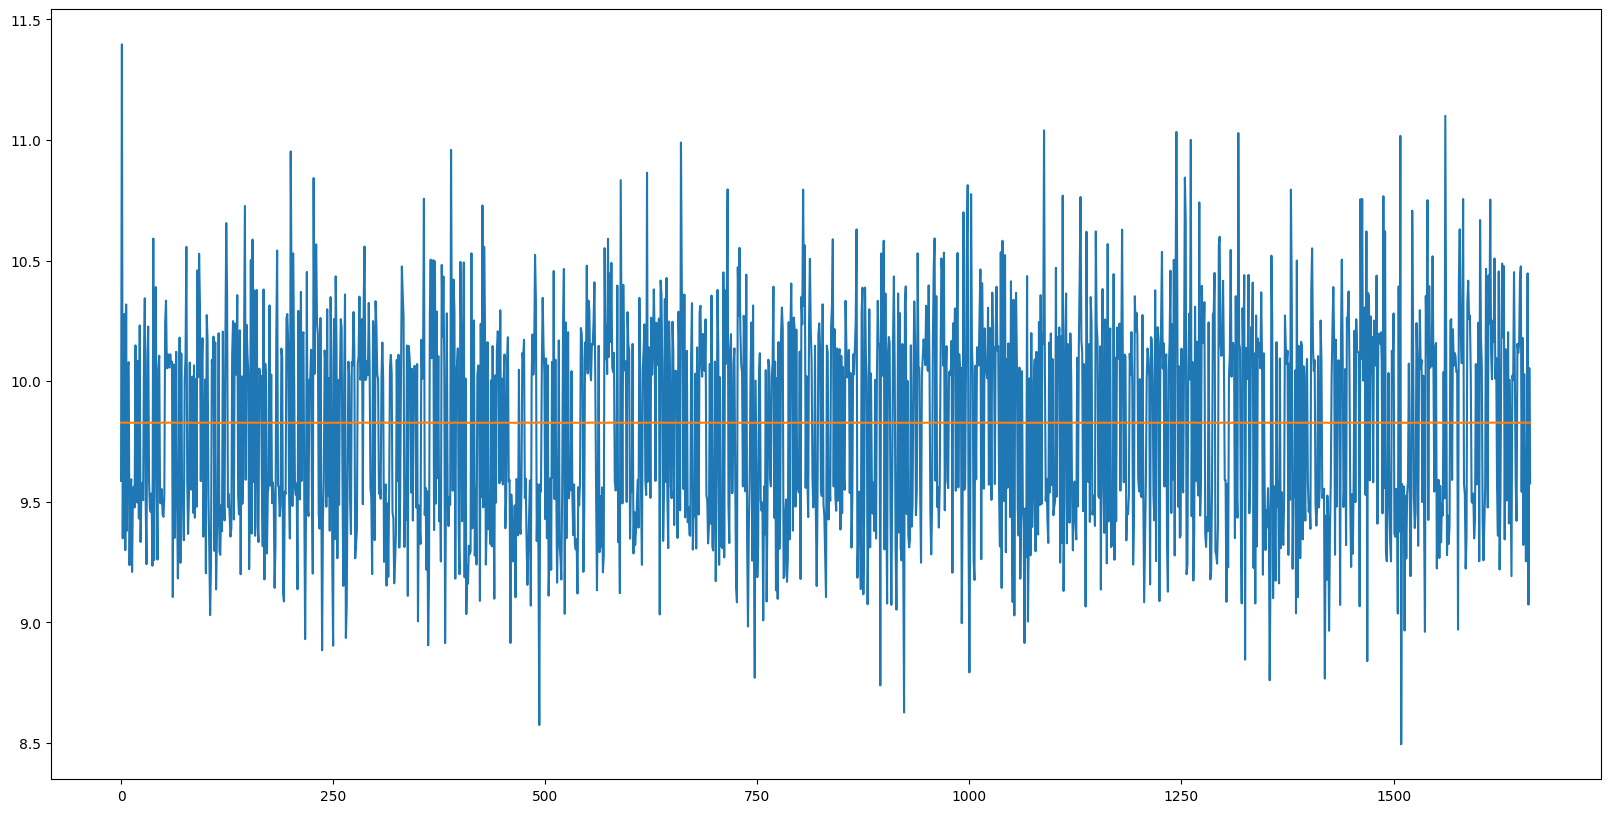

In [22]:
# Plot the predictions and actual values for the test set

plt.figure(figsize=(20,10))
plt.plot(test_results['Actual'])
plt.plot(test_results['Test Predictions'])